In [1]:

import re
import seaborn as sbn
import nltk
import tqdm as tqdm
import sqlite3
import pandas as pd
import numpy as np

import string
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words("english")
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from math import floor,ceil
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from gensim import summarization
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\15726\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\15726\anaconda3\envs\ds-1\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
review_data_or = pd.read_json('Beauty_5.json',lines=True)

In [3]:
review_data_or.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [4]:
review_data_or.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198502 entries, 0 to 198501
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      198502 non-null  object
 1   asin            198502 non-null  object
 2   reviewerName    197116 non-null  object
 3   helpful         198502 non-null  object
 4   reviewText      198502 non-null  object
 5   overall         198502 non-null  int64 
 6   summary         198502 non-null  object
 7   unixReviewTime  198502 non-null  int64 
 8   reviewTime      198502 non-null  object
dtypes: int64(2), object(7)
memory usage: 13.6+ MB


In [5]:
review_data=review_data_or.drop(['reviewerID','asin','reviewerName','summary'],axis=1)


In [6]:
from datetime import datetime
current_date = datetime.now()
# Define a function to calculate the time difference in days
def calculate_time_difference(review_time):
    return (current_date - datetime.strptime(review_time, "%m %d, %Y")).days

# Apply the function to the 'reviewTime' column and replace it
review_data['Review_Interval_Days'] = review_data['reviewTime'].apply(calculate_time_difference)
review_data = review_data.drop(['reviewTime'],axis=1)


In [7]:
review_data['reviewText'] = review_data['reviewText'].astype('string')


In [8]:
review_data.head()

,helpful,reviewText,overall,unixReviewTime,Review_Interval_Days
0,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,1391040000,3551
1,"[1, 1]",This palette was a decent price and I was look...,3,1397779200,3473
2,"[0, 1]",The texture of this concealer pallet is fantas...,4,1378425600,3697
3,"[2, 2]",I really can't tell what exactly this thing is...,2,1386460800,3604
4,"[0, 0]","It was a little smaller than I expected, but t...",3,1382140800,3654


In [9]:
reviews = review_data

reviews[['helpful','total']] = pd.DataFrame(reviews.helpful.values.tolist(), index=reviews.index)
############删掉没有评价是否有用的评论############################
reviews = reviews[reviews['total'] > 0]
#reviews["sentiment"] = reviews["overall"].apply(lambda score: 1 if score > 3 else 1)
reviews["usefulScore"] = (reviews["helpful"]/reviews["total"]).apply(lambda n: n if n > 0 else 0)
#.apply(lambda n: "useful" if n > 0.8 else "useless")

review_data = reviews.drop(['helpful','total'],axis=1)
review_data.head(10)


C:\Users\15726\AppData\Local\Temp\ipykernel_8820\3796216857.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews["usefulScore"] = (reviews["helpful"]/reviews["total"]).apply(lambda n: n if n > 0 else 0)


,reviewText,overall,unixReviewTime,Review_Interval_Days,usefulScore
0,Very oily and creamy. Not at all what I expect...,1,1391040000,3551,0.750000
1,This palette was a decent price and I was look...,3,1397779200,3473,1.000000
2,The texture of this concealer pallet is fantas...,4,1378425600,3697,0.000000
3,I really can't tell what exactly this thing is...,2,1386460800,3604,1.000000
5,"I was very happy to get this palette, now I wi...",5,1365984000,3841,0.500000
6,PLEASE DONT DO IT! this just rachett the palet...,1,1376611200,3718,0.333333
7,"Chalky,Not Pigmented,Wears off easily,Not a Co...",2,1378252800,3699,0.000000
12,"I bought this product about 3 months ago, I fi...",5,1390435200,3558,0.000000
14,i got this to get rid of a scar and it did jus...,5,1392681600,3532,0.000000
16,I order this cream along with their soap. It a...,5,1379116800,3689,0.500000


In [10]:
a = review_data['overall'].value_counts()
print(a)

5    46573
4    15709
3    10219
1     6999
2     6148
Name: overall, dtype: int64


# Data Cleaning

In [11]:
count = 0
for i in review_data['reviewText']:
    if i == '':
        
        count = count+1
count

22

In [12]:
review_data = review_data[review_data['reviewText'] != '']

In [13]:
import nltk
#nlp = spacy.load("en_core_web_sm")
# 下载NLTK的punkt句子分割模型（只需要执行一次）
nltk.download('punkt')

from nltk.tokenize import sent_tokenize

def split_sentences(text):

  try:
   punctuation = ['.', '!', '?']
    
        # 去除句子末尾的空格
   text = text.rstrip()
    
     # 检查句末是否有标点符号
   if text[-1] not in punctuation:
        # 如果没有标点符号，就添加一个句号
      text = f'{text}.'
   #sentences = sent_tokenize(text)

   return text
  except Exception as e:
    print(f"Error: {e}, Text: {text}")


review_data['reviewText']= review_data['reviewText'].apply(split_sentences)
#sample =split_sentences( review_data['reviewText'][9827])
#sample


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\15726\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
review_data.head()

,reviewText,overall,unixReviewTime,Review_Interval_Days,usefulScore
0,Very oily and creamy. Not at all what I expect...,1,1391040000,3551,0.75
1,This palette was a decent price and I was look...,3,1397779200,3473,1.00
2,The texture of this concealer pallet is fantas...,4,1378425600,3697,0.00
3,I really can't tell what exactly this thing is...,2,1386460800,3604,1.00
5,"I was very happy to get this palette, now I wi...",5,1365984000,3841,0.50


# SMOG指数可读性分析
SMOG指数是一种用于评估文本可读性的指标，它考虑了一个文本中的多音节词的数量。SMOG代表了“Simple Measure of Gobbledygook”（即“混乱简单度量”），是由罗伯特·克拉斯特（Robert Gunning）于1952年提出的。它旨在提供一个简单但有效的方法来估计一段文本的阅读难易程度。

In [15]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85626 entries, 0 to 198501
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewText            85626 non-null  object 
 1   overall               85626 non-null  int64  
 2   unixReviewTime        85626 non-null  int64  
 3   Review_Interval_Days  85626 non-null  int64  
 4   usefulScore           85626 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.9+ MB


In [16]:
sample_data = review_data.sample(n=10000, random_state=42)

In [17]:
sample_data

,reviewText,overall,unixReviewTime,Review_Interval_Days,usefulScore
149098,"About my hair: Long (middle of back), natural...",5,1339459200,4148,1.00
19400,This worked great on my daughter's back. There...,4,1235606400,5350,1.00
7100,Live this perfume. vanilla and sweet. I will...,5,1400025600,3447,1.00
166257,As a teen I developed very oily skin that has ...,4,1361491200,3893,0.75
155894,The USpicy Crescent USND-1801 Nail Polish Drye...,5,1397692800,3474,1.00
...,...,...,...,...,...
98066,I have combination skin and ordered this produ...,1,1368662400,3810,0.50
184871,"I'm not a beauty expert, but this is a great b...",5,1403136000,3411,1.00
152188,"I was really excited to receive my wig, the re...",1,1357084800,3944,0.60
17021,I recently came across information on Madam Gr...,4,1351641600,4007,0.80


In [18]:
sample_data.reviewText

149098    About my hair:  Long (middle of back), natural...
19400     This worked great on my daughter's back. There...
7100      Live this perfume.  vanilla and sweet.  I will...
166257    As a teen I developed very oily skin that has ...
155894    The USpicy Crescent USND-1801 Nail Polish Drye...
                                ...                        
98066     I have combination skin and ordered this produ...
184871    I'm not a beauty expert, but this is a great b...
152188    I was really excited to receive my wig, the re...
17021     I recently came across information on Madam Gr...
22418     My son and I both suffer with very dry skin, a...
Name: reviewText, Length: 10000, dtype: object

In [19]:
from textatistic import Textatistic

# 定义一个函数来计算SMOG指数
def calculate_smog(text):
    try:
        stats = Textatistic(text)
        return stats.smog_score
    except Exception as e:
        print(f"Error calculating SMOG for text: {e}/n{text}")
        return 0

# 示例用法
readability_scores = []

for i in sample_data.reviewText:
    smog = calculate_smog(i)
    readability_scores.append(smog)

sample_data['Readability_smog'] = readability_scores


Error calculating SMOG for text: Word to be hyphenated may have at most 100 characters./nMake your face smoother, look up younger, After use, your skin is smooth and soft,Wrinkle really disappear.Daily Resurfacing Disks and Deep Wrinkle Night Cream.it has a pleasant scent,It does seem to tingle a bit but not too much! My face feels super soft after using these and I notice that blemishes seem to disappear faster.&#20351;&#8203;&#20320;&#30340;&#8203;&#33225;&#26356;&#8203;&#24179;&#28369;&#8203;&#65292;&#30475;&#8203;&#36215;&#20358;&#8203;&#26356;&#24180;&#8203;&#36629;, &#20351;&#8203;&#29992;&#23427;&#8203;&#20497;, &#20320;&#8203;&#30340;&#30382;&#8203;&#33178;&#30475;&#8203;&#19978;&#21435;&#8203;&#26371;&#39023;&#8203;&#33879;&#26356;&#8203;&#8203;&#33287;&#38918;&#8203;&#26274;&#12290;&#8203;&#20320;&#21487;&#8203;&#20197;&#30495;&#8203;&#27491;&#24863;&#8203;&#21463;&#21040;&#8203;&#20320;&#30340;&#8203;&#33225;&#40657;&#8203;&#26001;&#28187;&#8203;&#23569;. &#20351;&#8203;&#29

In [20]:
from textstat import flesch_kincaid_grade, gunning_fog


# 示例用法
flesch_scores = []
gunning_scores = []

for i in sample_data.reviewText:
    fk_score = flesch_kincaid_grade(i)
    gf_score = gunning_fog(i)
    flesch_scores.append(fk_score)
    gunning_scores.append(gf_score)

sample_data['Readability_flesch'] = flesch_scores
sample_data['Readability_Gunning'] = gunning_scores

In [21]:
###字符
##单词数
sample_data['Readability_char_count'] = sample_data['reviewText'].apply(len)

# 计算单词数并添加为新列 'Word_Count'
sample_data['Word_Count'] = sample_data['reviewText'].apply(lambda x: len(x.split()))


## Test of SentimentIntensity Analysis极性分析


In [22]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
#sample_review = review_data.reviewText[:10]
Review_Polarity = []
for test in sample_data.reviewText:
    ss = analyser.polarity_scores(test) #极性分析
    #for k in sorted(ss):
        #print('{0}: {1}, '.format(k, ss[k]))
    Review_Polarity.append(ss['compound'])
    #print(test)
Review_Polarity[:10]
sample_data['Polarity'] = Review_Polarity

# 主观性分析 TextBlob


In [23]:
from textblob import TextBlob, Word, Blobber
sample_data['Subjectivity'] = sample_data['reviewText'].apply(lambda x: TextBlob(x).sentiment[1])



In [24]:
sample_data = sample_data.drop(['reviewText'],axis=1)

In [25]:
sample_data

,overall,unixReviewTime,Review_Interval_Days,usefulScore,Readability_smog,Readability_flesch,Readability_Gunning,Readability_char_count,Word_Count,Polarity,Subjectivity
149098,5,1339459200,4148,1.00,8.167269,6.3,6.78,1162,198,0.9932,0.551705
19400,4,1235606400,5350,1.00,7.168622,3.4,5.72,143,25,0.8779,0.570000
7100,5,1400025600,3447,1.00,6.427356,2.4,4.68,109,20,0.6908,0.550000
166257,4,1361491200,3893,0.75,9.725611,10.8,13.44,904,170,0.9783,0.344118
155894,5,1397692800,3474,1.00,7.348243,5.8,6.92,1361,250,0.9537,0.586243
...,...,...,...,...,...,...,...,...,...,...,...
98066,1,1368662400,3810,0.50,5.985473,4.2,6.34,250,47,-0.1815,0.400000
184871,5,1403136000,3411,1.00,9.188382,9.1,10.58,813,147,0.9420,0.398684
152188,1,1357084800,3944,0.60,7.793538,7.8,10.61,358,71,0.5849,0.673333
17021,4,1351641600,4007,0.80,11.088447,8.8,11.81,1697,293,0.9861,0.554526


# distribution of usefulScore is heavily skewed towards 0

In [26]:
sample_data.describe()

,overall,unixReviewTime,Review_Interval_Days,usefulScore,Readability_smog,Readability_flesch,Readability_Gunning,Readability_char_count,Word_Count,Polarity,Subjectivity
count,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,4.037200,1.351874e+09,4004.314700,0.709194,7.201601,5.834860,8.048708,593.300900,110.803300,0.64907,0.535905
std,1.300302,4.492256e+07,519.937048,0.360581,2.088342,2.820698,2.817833,602.283009,110.279104,0.47921,0.137185
min,1.000000,1.052611e+09,3378.000000,0.000000,0.000000,-3.100000,0.800000,9.000000,2.000000,-0.99050,0.000000
25%,3.000000,1.334686e+09,3645.000000,0.500000,6.093298,4.100000,6.350000,221.000000,42.000000,0.57190,0.460296
50%,5.000000,1.362960e+09,3876.000000,0.888889,7.168622,5.600000,7.830000,408.000000,77.000000,0.86925,0.532883
75%,5.000000,1.382918e+09,4203.250000,1.000000,8.548687,7.200000,9.370000,743.000000,140.000000,0.95540,0.610000
max,5.000000,1.405987e+09,7468.000000,1.000000,20.267339,46.900000,51.540000,11076.000000,1999.000000,0.99970,1.000000


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
b = sample_data.usefulScore.value_counts().sort_index()
b



0.000000    1513
0.066667       1
0.071429       1
0.076923       2
0.100000       2
            ... 
0.985714       1
0.986486       1
0.986667       1
0.986842       1
1.000000    4667
Name: usefulScore, Length: 260, dtype: int64

In [28]:
bins = pd.cut(sample_data['usefulScore'], bins=10)

# 计算每个区间的计数
counts = bins.value_counts().sort_index()
counts

(-0.001, 0.1]    1519
(0.1, 0.2]         55
(0.2, 0.3]         59
(0.3, 0.4]        221
(0.4, 0.5]       1223
(0.5, 0.6]        183
(0.6, 0.7]        645
(0.7, 0.8]        704
(0.8, 0.9]        468
(0.9, 1.0]       4923
Name: usefulScore, dtype: int64

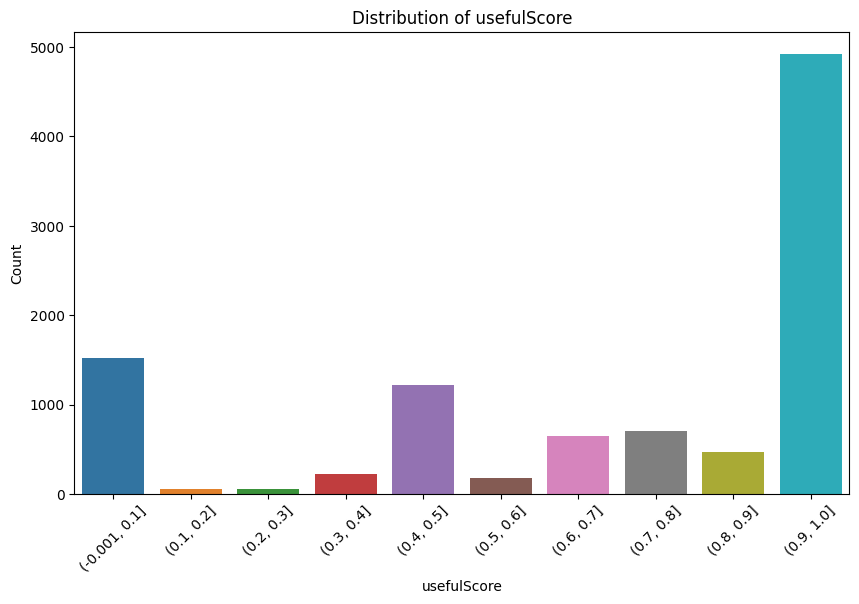

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 sample_data 包含了你的数据
# 例如：sample_data = pd.read_csv('your_data.csv')

# 将 usefulScore 列的值分成十个区间
bins = pd.cut(sample_data['usefulScore'], bins=10)

# 计算每个区间的计数
counts = bins.value_counts().sort_index()

# 绘制 barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel('usefulScore')
plt.ylabel('Count')
plt.title('Distribution of usefulScore')
plt.xticks(rotation=45)
plt.show()


# 样本不均衡，AUC=0.5


In [30]:
b

0.000000    1513
0.066667       1
0.071429       1
0.076923       2
0.100000       2
            ... 
0.985714       1
0.986486       1
0.986667       1
0.986842       1
1.000000    4667
Name: usefulScore, Length: 260, dtype: int64

In [31]:
from sklearn.preprocessing import MinMaxScaler

# 初始化MinMaxScaler
scaler = MinMaxScaler()


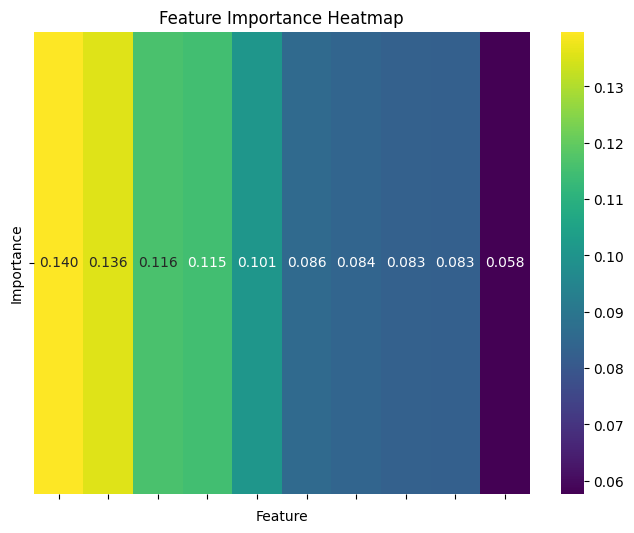

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Assuming 'data' contains the features and labels (overall, Review_Interval_Days, Readability, Polarity)
# X contains the features, y contains the labels


y = sample_data['usefulScore'].values
X = sample_data.drop(columns='usefulScore')

#######数不需要归一化

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X, y)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame with feature names and their importances
importance_df = pd.DataFrame({'Feature': sample_data.columns.tolist().remove('usefulScore'),
                              'Importance': feature_importances})


# Create the heatmap
plt.figure(figsize=(8, 6))
heatmap_data = importance_df.set_index('Feature')['Importance'].sort_values(ascending=False).to_frame().T
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='.3f')
plt.title('Feature Importance Heatmap')
plt.show()

In [33]:
# 不用交叉验证，没必要，时间长，结果差不多
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


y = sample_data['usefulScore'].values
X = sample_data.drop(columns='usefulScore')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [34]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
threshold = 0.4

In [35]:
#################处理样本不平衡

from sklearn.utils import resample

# 将数据分成特征 (X) 和目标 (y)
# 替换成你的特征数据
y = sample_data['usefulScore']  # 替换成你的目标数据

y.value_counts()


1.000000    4667
0.000000    1513
0.500000    1203
0.666667     529
0.750000     343
            ... 
0.910256       1
0.267857       1
0.890805       1
0.538462       1
0.940594       1
Name: usefulScore, Length: 260, dtype: int64

# 平衡样本

In [36]:

# 将数据分成正例和负例
positive_samples = sample_data[y > threshold]
negative_samples = sample_data[y <= threshold]

# 从负例中随机采样生成合成样本
synthetic_samples = resample(negative_samples, n_samples=len(positive_samples), random_state=42)

# 将正例和合成样本合并
balanced_data = pd.concat([positive_samples, synthetic_samples])

# balanced_data 包含了处理后的平衡数据，你可以将其用于训练模型
X = balanced_data.drop(columns='usefulScore')
y = balanced_data['usefulScore'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_binary = (y_train > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)

In [37]:
balanced_data['usefulScore'].value_counts()

0.000000    6602
1.000000    4667
0.500000    1203
0.333333     782
0.666667     529
            ... 
0.905263       1
0.807692       1
0.861111       1
0.977778       1
0.985507       1
Name: usefulScore, Length: 260, dtype: int64

In [38]:

##################随机森林

##过拟合，减少树的数量

rf_model = RandomForestClassifier(n_estimators=20, random_state=42)  #100->10

# 使用交叉验证评估模型性能
# cv 参数指定了将数据集分成几份进行交叉验证，这里使用了 5 折交叉验证
# scoring 参数指定了评估指标，比如 'accuracy' 代表准确率
scores = cross_val_score(rf_model, X_train, y_train_binary, cv=5, scoring='accuracy')
rf_model.fit(X_train,y_train_binary)

# 输出交叉验证的结果
print("Cross-validated Accuracy:", scores)
print("Mean Accuracy:", scores.mean())

# 在测试集上评估模型性能
accuracy = rf_model.score(X_test, y_test_binary)
print(f'Test Accuracy: {accuracy}')

Cross-validated Accuracy: [0.90372075 0.89758343 0.89873418 0.89025326 0.89178818]
Mean Accuracy: 0.8964159602180916
Test Accuracy: 0.9312672598956735


In [39]:
y_test_binary.mean()

0.49002761583307763

In [41]:
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
# 使用 roc_auc_score 函数计算AUC
y_pred = rf_model.predict(X_test)
y_pred_binary = (rf_model.predict(X_test) > threshold).astype(int)
auc_score = roc_auc_score(y_test_binary, y_pred_binary)

print(f"AUC Score: {auc_score}")
r2 = r2_score(y_test, y_pred)
print(r2)

AUC Score: 0.9302235991521407
0.5479872543442474


# 每个变量

In [43]:


# Assuming 'data' contains the features and labels (overall, Review_Interval_Days, Readability, Polarity)
# X contains the features, y contains the labels
features = sample_data.columns.tolist()
features.remove('usefulScore')

outcome = []
threshold = 0.4

for i in features:
    X_train1 = X_train[[i]].values.reshape(-1, 1)  # Use the feature 'i'
    X_test1 = X_test[[i]].values.reshape(-1, 1) 

    # Convert usefulScore to binary labels
    y_train_binary = (y_train > threshold).astype(int)
    # Train the model
    rf_model.fit(X_train1, y_train_binary)
    y_test_binary = (y_test > threshold).astype(int)
    y_pred_binary = (rf_model.predict(X_test1) > threshold).astype(int)
    y_pred = rf_model.predict(X_test1) 

    # Evaluate the model
    auc = roc_auc_score(y_test_binary, y_pred_binary)
    #r2 = r2_score(y_test, y_pred)
    accuracy = rf_model.score(X_test1, y_test_binary)
    outcome.append(f'AUC for {i}: {auc}, {accuracy}')
outcome

['AUC for overall: 0.5990376058599646, 0.5995704203743479',
 'AUC for unixReviewTime: 0.6621900118076387, 0.664007364222154',
 'AUC for Review_Interval_Days: 0.6631415176018212, 0.6649278919914084',
 'AUC for Readability_smog: 0.5728886216409076, 0.5750230131942313',
 'AUC for Readability_flesch: 0.5454718421348089, 0.545872967167843',
 'AUC for Readability_Gunning: 0.6376923639163987, 0.6388462718625345',
 'AUC for Readability_char_count: 0.6533256173013932, 0.6554157717091132',
 'AUC for Word_Count: 0.5946385634315846, 0.5961951518870819',
 'AUC for Polarity: 0.7508109745483975, 0.7526848726603252',
 'AUC for Subjectivity: 0.7641704851229028, 0.7661859466093894']